In [5]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random
import face_recognition

In [3]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    if pred_cls[i]=='person':
        print (boxes[i])
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]


[(386.81317, 414.18982), (560.55597, 695.33551)]
[(198.2274, 377.91721), (364.01834, 675.17249)]
[(857.35907, 362.44958), (1062.0813, 694.33459)]
[(556.67853, 410.66571), (727.17584, 692.59912)]
[(29.440071, 371.17157), (213.65204, 668.5741)]
[(28.580929, 210.81554), (170.72049, 506.21033)]
[(158.43283, 187.82115), (300.66788, 452.75534)]
[(783.10284, 357.17703), (905.96094, 655.20227)]
[(916.42157, 188.13254), (1013.7084, 448.19202)]
[(803.53967, 171.1492), (932.2627, 435.47485)]
[(690.19147, 356.24448), (815.96045, 646.06177)]
[(991.45886, 239.94424), (1039.5419, 396.16013)]
[(289.06467, 235.57726), (388.45129, 567.15405)]
[(735.72339, 226.74629), (814.22711, 429.69522)]
[(675.64917, 196.96884), (751.85211, 455.987)]
[(351.67572, 369.5853), (456.36212, 609.88605)]
[(370.50079, 188.41011), (472.16617, 435.44135)]
[(249.25252, 176.43719), (318.33319, 276.14435)]
[(445.10962, 206.56268), (516.21393, 420.83545)]
[(583.1203, 192.17181), (687.62842, 471.28879)]
[(309.81064, 177.90579), (38

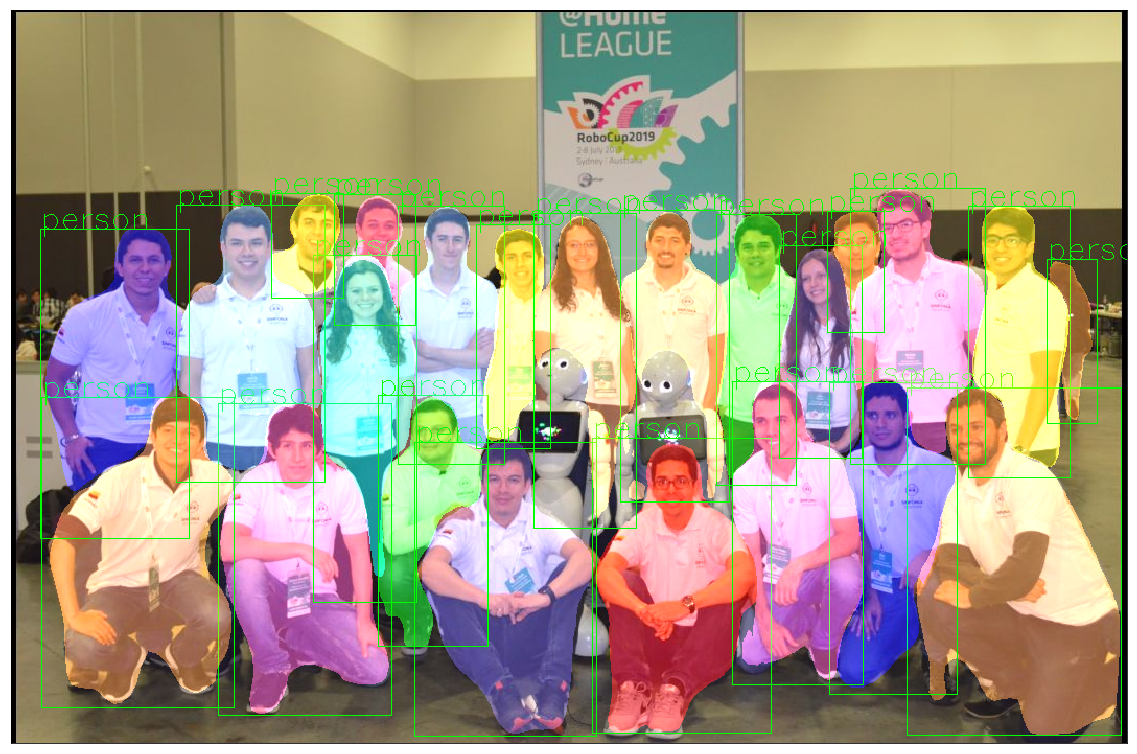

In [4]:
#!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O mrcnn_standing_people.jpg
instance_segmentation_api('./group.jpg', 0.75,1,1,1)

# Comparing the inference time of model in CPU & GPU



In [35]:
import time

def check_inference_time(image_path, gpu=False):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  model.eval()
  img = Image.open(image_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  if gpu:
    model.cuda()
    img = img.cuda()
  else:
    model.cpu()
    img = img.cpu()
  start_time = time.time()
  pred = model([img])
  end_time = time.time()
  return end_time-start_time

In [40]:
cpu_time = sum([check_inference_time('./person.jpg', gpu=False) for _ in range(1)])/1.0
#gpu_time = sum([check_inference_time('./person.jpg', gpu=True) for _ in range(5)])/5.0


print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(4, cpu_time))



Average Time take by the model with GPU = 4s
Average Time take by the model with CPU = 3.2730495929718018s
